# Data Extractions from OpenEO

To run the extractions, you need an account in the [Copernicus Data Space Ecosystem (CDSE)](https://dataspace.copernicus.eu/).

In [2]:
!pip install git+https://github.com/WorldCereal/prometheo.git --quiet
!pip install git+https://github.com/ScaleAGData/scaleag-vito.git --quiet

In [3]:
from pathlib import Path
import geopandas as gpd
from loguru import logger
from scaleagdata_vito.presto.datasets_prometheo import ScaleAgDataset
from scaleagdata_vito.openeo.extract_sample_scaleag import generate_input_for_extractions, extract
from scaleagdata_vito.presto.presto_df import load_dataset
from scaleagdata_vito.presto.utils import train_test_val_split, finetune_on_task, load_finetuned_model, evaluate_finetuned_model, get_pretrained_model_url
from scaleagdata_vito.presto.inference import PrestoPredictor, reshape_result, plot_results
from scaleagdata_vito.utils.map import ui_map
from scaleagdata_vito.utils.dateslider import date_slider
from scaleagdata_vito.openeo.extract_sample_scaleag import collect_inputs_for_inference

### Before we start...

**Check your data!** Investigate validity of geometries uniqueness of sample IDs, presence of outliers and so on before starting the extraction. Achieving good performance making use of a limited amount of data is a challening task per se. Therefore, **the quality of your data will greatly impact your final results.**

Data requirements:
- Points or Polygons (will be aggregated in points)
- Lat-Lon (crs:4326) 
- Format: parquet, GeoJSON, shapefile, GPKG
For each geometry:
- Date (if available) 
- Unique ID
- Annotations

Good practice:

Remove polygons close to borders (e.g. apply buffer) to ensure data are contained in the field
If the annotations are accurate, point geometries should be preferred. However, especially in regression tasks (i.e., continuous output values) such us yield estimation the target values might be noisy. In that case, we recommend subdividing the polygons in subfields of 20m x 20m (to cover more measurements) and computing the median yield for a smoother and more reliable target

#### Assess data correctness before launching the OpenEO jobs 
You can run some checks on your input file to make sure they are suitable to run the extractions successfully. In particular, it is important to check the validity of the geometries and, ideally, to also have a column containing a unique id for each sample.

In case of invalid geometries, you will be provided with both the dataframe with the failing polygons to be fixed and the one with valid geometries.

In [4]:
def check_unique_id(df_path, unique_id):
    df = gpd.read_file(df_path)
    if df[unique_id].nunique() != df.shape[0]:
        logger.info("IDs are not unique!")
        return df[df[unique_id].duplicated(keep=False)]
    else:
        logger.info("IDs are unique")
        return None

def check_valid_geometry(df):
    if isinstance(df, str):
        df = gpd.read_file(df)
    df_invalid = df[~df.geometry.is_valid]
    # Assessing wheather some invalid geometries are present
    if len(df_invalid) > 0:
        # 1) some invalid geometries are present. Attempt fixing them
        df['geometry'] = df.geometry.buffer(0)
        df_invalid = df[~df.geometry.is_valid]
        df_valid = df[df.geometry.is_valid]
        if len(df_invalid) > 0:
            # 2) Still some invalid geometries are present. Return them
            logger.info("Invalid geometries found! Returning invalid geometries")
            return df_invalid, df_valid
        else:
            # All geometries are now valid. Return fixed dataframe and empty dataframe for invalid geometries
            logger.info("Fixed some invalid geometries. All geometries are now valid")
            return gpd.GeoDataFrame(), df
    else:
        # All geometries are valid. Return empty dataframe for invalid geometries
        logger.info("All geometries are valid")
        return gpd.GeoDataFrame(), df

def _save(save_to, original_file_path, df, suffix=''):
    if suffix!='':
        filename = Path(save_to) / f"{Path(original_file_path).stem}_{suffix}.geojson"
    else:
        filename = Path(save_to) / f"{Path(original_file_path).stem}.geojson"
    logger.info(f"Saving invalid geometries to {filename}")
    Path(save_to).mkdir(parents=True, exist_ok=True)
    df.to_file(filename)

In [5]:
input_file = "/home/giorgia/Private/data/geomaize/correct/Maize_North_Ghana_valid.geojson"
invalid_geom, valid_geom = check_valid_geometry(input_file)
non_unique_ids = check_unique_id(input_file, unique_id="Field_id")

2025-07-17 15:36:36.800 | INFO     | __main__:check_valid_geometry:30 - All geometries are valid
2025-07-17 15:36:36.828 | INFO     | __main__:check_unique_id:7 - IDs are unique


In [6]:
# save files after geometry validity check. If invalid geometries are present, save them to a separate file
if len(invalid_geom) > 0:
    _save(
        save_to="/home/giorgia/Private/data/geomaize/invalid/",
        original_file_path=input_file,
        df=invalid_geom,
        suffix='',
    )

# save valid geometries to a separate file
_save(
    save_to="/home/giorgia/Private/data/geomaize/correct/",
    original_file_path=input_file,
    df=valid_geom,
    suffix='',
)

2025-07-17 15:36:38.961 | INFO     | __main__:_save:38 - Saving invalid geometries to /home/giorgia/Private/data/geomaize/correct/Maize_North_Ghana_valid.geojson


#### Requirements for running the extractions
- Account in [Copernicus Data Space Ecosystem (CDSE)](https://dataspace.copernicus.eu/). You can sign up for free and have a monthly availability of 10000 credits.
- A dataset with valid geometries (Points or Polygons) in lat-lon projection.
- Preferably a dataset with unique IDs per sample 
- A labelled dataset. Not required for the extraction process, but for the following fine-tuning steps.

#### EO data extractions
In this first step, we extract for each sample in your dataset the required EO time series from CDSE using OpenEO.
For running the job, the user should indicate the following job_dictionary fields:

```python
    job_params = dict(
        output_folder=..., # where to save the extracted dataset
        input_df=..., # input georeferenced dataset to run the extractions for 
        start_date=..., # string indicating from which date to extract data  
        end_date=..., # string indicating until which date to extract the data 
        unique_id_column=..., # name of the column in the input_df containing the unique ID of the samples  
        composite_window=..., # "month" or "dekad" are supported. Default is "dekad"
    )
```
in particular:
- If the `date` information associated with the label is provided, the `start_date` of the time-series is automatically set to 9 months before the date, whereas the `end_date` is set to 9 months after. If `date` is not available, the user needs to manually indicate the desired `start_date` and `end_date` for the extractions.
- `composite_window` indicates the time-series granularity, which can be dekadal or monthly. 
  - `dekad`: each time step in the extracted time series corresponds to a mean-compositing operation on 10-days acquisitions. Accordingly with the start and end date, each month will be covered by 3 time steps which, by default, correspond to the 1st, 11th and 21th of the month. 
  - `month`: each time step in the extracted time series corresponds to a mean-compositing operation on 30-days acquisitions. Each month will be covered by 1 time step which, by default, correspond to the 1st of the month.

The following decadal/monthly time series will be extracted for the indicated time range:

- Sentinel-2 L2A data (all bands)
- Sentinel-1 VH and VV
- Average air temperature and precipitation sum derived from AgERA5
- Slope and elevation from Copernicus DEM

Presto accepts 1D time-series. Therefore, if Polygons are provided for the extractions, the latter are spatially aggregated in points which will correspond to the centroid lat lon geolocation.

### 1) Run extractions

In [7]:
# Dataset Parameters
start_date="2021-07-01"
end_date="2021-10-31"
composite_window="dekad"
unique_id_column="Field_id"
input_df="/home/giorgia/Private/data/geomaize/correct/Maize_North_Ghana_valid.geojson"
output_folder="/home/giorgia/Private/data/geomaize/extractions_North_Ghana/"

In [8]:
# check input data structure 
gpd.read_file(input_df) 

,Field_id,Crop,Area(acre),COMMUNITY,REGION,Season,Year,Type,geometry
0,2042JIM,maize,1.580000,JIMLE,NORTHERN,July-October,2021,Mono Cropping,"POLYGON Z ((-0.50654 9.39554 154.28076, -0.506..."
1,3013BAD,Maize,0.763880,BADIGU,Northern,July-October,2021,Mono Cropping,"POLYGON Z ((-0.69446 9.5687 0, -0.69448 9.5686..."
2,4034CHI,Maize,2.562025,Chahandayili,Savanna,July-October,2021,Mono Cropping,"POLYGON Z ((-0.4552 9.22023 0, -0.45521 9.2203..."
3,4019CHI,Maize,0.877704,Chehandayili,Savanna,July-October,2021,Mono Cropping,"POLYGON Z ((-0.44707 9.22686 0, -0.44714 9.226..."
4,4037CHI,Maize,1.897256,Chahandayili,Savanna,July-October,2021,Mono Cropping,"POLYGON Z ((-0.44376 9.22794 0, -0.4438 9.2280..."
...,...,...,...,...,...,...,...,...,...
178,33036TAM,maize,1.396200,Tampion,NORTHERN,July-October,2021,Mono Cropping,"POLYGON Z ((-0.65362 9.58636 0, -0.65343 9.586..."
179,33048TAM,maize,1.314670,Tampion,NORTHERN,July-October,2021,Mono Cropping,"POLYGON Z ((-0.64357 9.5811 0, -0.64336 9.5810..."
180,33051TAM,maize,1.828420,Tampion,NORTHERN,July-October,2021,Mono Cropping,"POLYGON Z ((-0.64344 9.57268 0, -0.64331 9.572..."
181,33061TAM,maize,2.347370,Tampion,NORTHERN,July-October,2021,Mono Cropping,"POLYGON Z ((-0.61294 9.56017 0, -0.61288 9.560..."


In [9]:
job_params = dict(
    output_folder=output_folder,
    input_df=input_df,
    unique_id_column=unique_id_column,
    composite_window=composite_window,
)
extract(generate_input_for_extractions(job_params))

2025-07-17 15:36:41,628|extraction_pipeline|INFO:  Loading input dataframe from /home/giorgia/Private/data/geomaize/correct/Maize_North_Ghana_valid.geojson.
2025-07-17 15:36:41,657|extraction_pipeline|INFO:  Setting up the extraction functions.
2025-07-17 15:36:41,658|extraction_pipeline|INFO:  Initializing the job manager.
2025-07-17 15:36:41,659|extraction_pipeline|INFO:  Launching the jobs manager.
2025-07-17 15:36:41,659|openeo_gfmap.manager|INFO:  Starting ThreadPoolExecutor with 4 workers.
2025-07-17 15:36:41,662|openeo_gfmap.manager|INFO:  Creating and running jobs.
2025-07-17 15:36:41,675|openeo_gfmap.manager|INFO:  Quitting job tracking & waiting for last post-job actions to finish.
2025-07-17 15:36:41,675|openeo_gfmap.manager|INFO:  Exiting ThreadPoolExecutor.
2025-07-17 15:36:41,676|openeo_gfmap.manager|INFO:  All jobs finished running.
2025-07-17 15:36:41,676|openeo_gfmap.manager|INFO:  STAC was disabled, skipping generation of the catalogue.
2025-07-17 15:36:41,676|extract

Once the dataset will be extracted, it can be loaded with the `load_dataset` function by specifying the path where the `.parquet` files have been downloaded. Moreover, the following manipulations of the dataset are also possible:

- `window_of_interest`: the user can specify a time window of interest out of the whole available time-series. `start_date` and `end_date` should be provided as strings in a list.
- `use_valid_time`: the user might want to define the window of interest based on the `date` the label is associated with. If so, also `required_min_timesteps` should be provided
- `buffer_window`: buffers the `start_date` and `end_date` by the number of time steps here specified  

In the following cell, we load the extracted dataset for 1 year of data.

**NOTE:** this code currently assumes that we are dealing with 1 year of data falling in the same time period

### 2) Presto datasets initialization

In [ ]:
train_path = "/home/giorgia/Private/data/geomaize/extractions_2021"
valid_path = "/home/giorgia/Private/data/geomaize/extractions_2022"
test_path = "/home/giorgia/Private/data/geomaize/extractions_2023"

train_df = load_dataset(
    train_path,
    # window_of_interest=[start_date, end_date],
    composite_window=composite_window
    )

val_df = load_dataset(
    valid_path,
    # window_of_interest=[start_date, end_date],
    composite_window=composite_window
    )

test_df = load_dataset(
    test_path,
    window_of_interest=[start_date, end_date],
    composite_window=composite_window
    )

100%|██████████| 1/1 [00:00<00:00, 19.59it/s]


We now set up the parameters needed for initializing presto datasets for the specific task:
- `num_timesteps`: can be inferred by the max number of the `available_timesteps` 
- `target_name`: name of the column containing the target data
- `upper_bound` and `lower_bound`: these should be set to the min and max of the distribution. Therefore, it is important to get rid of potential outlaiers beforehand.

**NOTE:** upper and lower bounds are also used to normalize the targets during the training process. Therefore it is important to keep track of such values to convert the predictions to the original units in the inference step!  

We now set up the parameters needed for initializing presto datasets for the specific task:
- `num_timesteps`: can be inferred by the max number of the `available_timesteps` 
- `target_name`: name of the column containing the target data
- `upper_bound` and `lower_bound`: these should be set to the min and max of the distribution. Therefore, it is important to get rid of potential outlaiers beforehand.

**NOTE:** upper and lower bounds are also used to normalize the targets during the training process. Therefore it is important to keep track of such values to convert the predictions to the original units in the inference step!  

In [11]:
# visualize distribution to check for outliers to exclude if needed
num_timesteps = train_df.available_timesteps.max()
task_type = "regression"
target_name="Yield kg/H"
upper_bound = train_df[target_name].max() 
lower_bound = 0 

We Initialize the training, validation and test datasets objects to be used for training Presto.

In [12]:
train_ds = ScaleAgDataset(
    dataframe=train_df,
    num_timesteps=num_timesteps,
    task_type=task_type,
    target_name=target_name,
    composite_window=composite_window,
    upper_bound=train_df[target_name].max(),
    lower_bound=lower_bound,
)

# best practice is for the target_name to be consistent across datasets. 
# if so this only need to be defined in the cell above, and the string passed to the following datasets
# as target_name should be replaced by target_name (i.e. target_name="Kg/ha" -> target_name=target_name)

val_ds = ScaleAgDataset(
    dataframe=val_df,
    num_timesteps=num_timesteps,
    task_type=task_type,
    target_name="Kg/ha",
    composite_window=composite_window,
    upper_bound=upper_bound,
    lower_bound=lower_bound,
)

test_ds = ScaleAgDataset(
    dataframe=test_df,
    num_timesteps=num_timesteps,
    task_type=task_type,
    target_name="Kg/ha",
    composite_window=composite_window,
    upper_bound=upper_bound,
    lower_bound=lower_bound,
)


2025-07-17 15:36:49.064 | INFO     | scaleagdata_vito.presto.datasets_prometheo:set_num_outputs:140 - Setting number of outputs to 1 for regression task.
2025-07-17 15:36:49.075 | INFO     | scaleagdata_vito.presto.datasets_prometheo:set_num_outputs:140 - Setting number of outputs to 1 for regression task.
2025-07-17 15:36:49.082 | INFO     | scaleagdata_vito.presto.datasets_prometheo:set_num_outputs:140 - Setting number of outputs to 1 for regression task.


### 3) Presto Finetuning

In this section Presto will be Fine-Tuned in a supervised way for the target downstream task. first we set up the following experiment parameters:

- `output_dir` : where to dave the model 
- `experiment_name` : the model name

In [13]:
# Set model Hyperparameters
model_output_dir = Path("/home/giorgia/Private/data/geomaize/models/")
experiment_name = "presto-ss-wc-10D-ft-dek_geomaize"

In [14]:
# Construct the model with finetuning head starting from the pretrained model
finetuned_model = finetune_on_task(
    train_ds=train_ds,
    val_ds=val_ds,
    pretrained_model_path=get_pretrained_model_url(composite_window=composite_window),
    output_dir=model_output_dir, 
    experiment_name=experiment_name,
    num_workers=0,
    )
evaluate_finetuned_model(finetuned_model, test_ds, num_workers=0, batch_size=32)

2025-07-17 15:21:54.763 | INFO     | scaleagdata_vito.presto.utils:finetune_on_task:215 - Finetuning the model on regression task
2025-07-17 15:21:54.771 | INFO     | prometheo.finetune:_setup:237 - Using output dir: /data/users/Private/giorgia/data/geomaize/models


Finetuning:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-17 15:21:58.669 | INFO     | prometheo.finetune:_train_loop:192 - PROGRESS after Epoch 1/50: Epoch 1/50 | Train Loss: 0.0506 | Val Loss: 0.1937 | Val Acc: 0.279 | Val Macro F1: 0.218 | Best Loss: 0.1937 (improved)


Training:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-17 15:21:58.865 | INFO     | prometheo.finetune:_train_loop:192 - PROGRESS after Epoch 2/50: Epoch 2/50 | Train Loss: 0.0468 | Val Loss: 0.1816 | Val Acc: 0.279 | Val Macro F1: 0.218 | Best Loss: 0.1816 (improved)


Training:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-17 15:21:59.021 | INFO     | prometheo.finetune:_train_loop:192 - PROGRESS after Epoch 3/50: Epoch 3/50 | Train Loss: 0.0441 | Val Loss: 0.1710 | Val Acc: 0.279 | Val Macro F1: 0.218 | Best Loss: 0.1710 (improved)


Training:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-17 15:21:59.184 | INFO     | prometheo.finetune:_train_loop:192 - PROGRESS after Epoch 4/50: Epoch 4/50 | Train Loss: 0.0424 | Val Loss: 0.1622 | Val Acc: 0.279 | Val Macro F1: 0.218 | Best Loss: 0.1622 (improved)


Training:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-17 15:21:59.356 | INFO     | prometheo.finetune:_train_loop:192 - PROGRESS after Epoch 5/50: Epoch 5/50 | Train Loss: 0.0416 | Val Loss: 0.1552 | Val Acc: 0.279 | Val Macro F1: 0.218 | Best Loss: 0.1552 (improved)


Training:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-17 15:21:59.516 | INFO     | prometheo.finetune:_train_loop:192 - PROGRESS after Epoch 6/50: Epoch 6/50 | Train Loss: 0.0414 | Val Loss: 0.1500 | Val Acc: 0.279 | Val Macro F1: 0.218 | Best Loss: 0.1500 (improved)


Training:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-17 15:21:59.676 | INFO     | prometheo.finetune:_train_loop:192 - PROGRESS after Epoch 7/50: Epoch 7/50 | Train Loss: 0.0416 | Val Loss: 0.1465 | Val Acc: 0.279 | Val Macro F1: 0.218 | Best Loss: 0.1465 (improved)


Training:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-17 15:21:59.830 | INFO     | prometheo.finetune:_train_loop:192 - PROGRESS after Epoch 8/50: Epoch 8/50 | Train Loss: 0.0418 | Val Loss: 0.1445 | Val Acc: 0.279 | Val Macro F1: 0.218 | Best Loss: 0.1445 (improved)


Training:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-17 15:21:59.979 | INFO     | prometheo.finetune:_train_loop:192 - PROGRESS after Epoch 9/50: Epoch 9/50 | Train Loss: 0.0419 | Val Loss: 0.1435 | Val Acc: 0.279 | Val Macro F1: 0.218 | Best Loss: 0.1435 (improved)


Training:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-17 15:22:00.129 | INFO     | prometheo.finetune:_train_loop:192 - PROGRESS after Epoch 10/50: Epoch 10/50 | Train Loss: 0.0418 | Val Loss: 0.1436 | Val Acc: 0.279 | Val Macro F1: 0.218 | Best Loss: 0.1435 (no improvement for 1 epochs)


Training:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-17 15:22:00.468 | INFO     | prometheo.finetune:_train_loop:192 - PROGRESS after Epoch 11/50: Epoch 11/50 | Train Loss: 0.0414 | Val Loss: 0.1443 | Val Acc: 0.279 | Val Macro F1: 0.218 | Best Loss: 0.1435 (no improvement for 2 epochs)


Training:   0%|          | 0/1 [00:00<?, ?it/s]

2025-07-17 15:22:00.641 | INFO     | prometheo.finetune:_train_loop:173 - Early stopping!
2025-07-17 15:22:00.687 | INFO     | prometheo.finetune:run_finetuning:355 - Finetuning done
2025-07-17 15:22:00.689 | INFO     | scaleagdata_vito.presto.utils:evaluate_finetuned_model:108 - Evaluating the finetuned model on regression task


{'RMSE': 1164.3414984445071,
 'R2_score': -0.3026844263076782,
 'explained_var_score': -0.06476986408233643,
 'MAPE': 0.39721816778182983}

### 4) Inference using Fine-Tuned end-to-end Presto

In this section, we apply the fine tuned model to generate a yield map on an unseen area. 
We need to indicate the spatial and temporal extent. The 2 cells below, offer a simple way for the user to provide these information and perform once again the extraction from CDSE of the EO time-series required by Presto. 
We also need to indicate the `output_dir` of where to save the datacube of the extraction, its `output_filename` and the `composite_window` which will be the same as used for finetuning the model.

In [14]:
map = ui_map(area_limit=7)

In [15]:
# select 1 year of data
slider = date_slider()

In [16]:
output_dir = Path("/home/giorgia/Private/data/geomaize/regression")
output_filename = "inference_area"
inference_file = output_dir / f"{output_filename}.nc"

In [17]:
collect_inputs_for_inference(
    spatial_extent=map.get_extent(),
    temporal_extent=slider.get_processing_period(),
    output_path=output_dir,
    output_filename=f"{output_filename}.nc",
    composite_window=composite_window,
)

2025-07-17 15:42:43.939 | INFO     | scaleagdata_vito.utils.dateslider:get_processing_period:187 - Selected processing period: 2021-07-01 to 2022-06-30


Visit https://identity.dataspace.copernicus.eu/auth/realms/CDSE/device?user_code=ADFR-EJEC 📋 to authenticate.

✅ Authorized successfully

Authenticated using device code flow.
0:00:00 Job 'j-2507171343174ccc898a81f9a1125607': send 'start'
0:00:13 Job 'j-2507171343174ccc898a81f9a1125607': created (progress 0%)
0:00:18 Job 'j-2507171343174ccc898a81f9a1125607': created (progress 0%)
0:00:24 Job 'j-2507171343174ccc898a81f9a1125607': created (progress 0%)
0:00:32 Job 'j-2507171343174ccc898a81f9a1125607': created (progress 0%)
0:00:42 Job 'j-2507171343174ccc898a81f9a1125607': created (progress 0%)
0:00:55 Job 'j-2507171343174ccc898a81f9a1125607': running (progress N/A)
0:01:10 Job 'j-2507171343174ccc898a81f9a1125607': running (progress N/A)
0:01:29 Job 'j-2507171343174ccc898a81f9a1125607': running (progress N/A)
0:01:53 Job 'j-2507171343174ccc898a81f9a1125607': running (progress N/A)
0:02:23 Job 'j-2507171343174ccc898a81f9a1125607': running (progress N/A)
0:03:01 Job 'j-2507171343174ccc898a81f9a1125607': running (progress N/A)
0:03:47 Job 'j-2507171343174ccc898a81f9a1125607': running (progress N/A)
0:04:46 Job 'j-2507171343174

Once the datacube has been extracted, we can perform the inference task using the finetuned model and visualize the predicted map. 

In [20]:
inference_file = output_dir / "inference_area.nc"
mask_path = None

In [21]:
finetuned_model = load_finetuned_model(model_output_dir / experiment_name, task_type=task_type)
presto_model = PrestoPredictor(
    model=finetuned_model,
    batch_size=50,
    task_type=task_type,
    composite_window=composite_window,
)

predictions = presto_model.predict(inference_file, upper_bound=upper_bound, lower_bound=lower_bound, mask_path=mask_path)
predictions_map = reshape_result(predictions, path_to_input_file=inference_file)

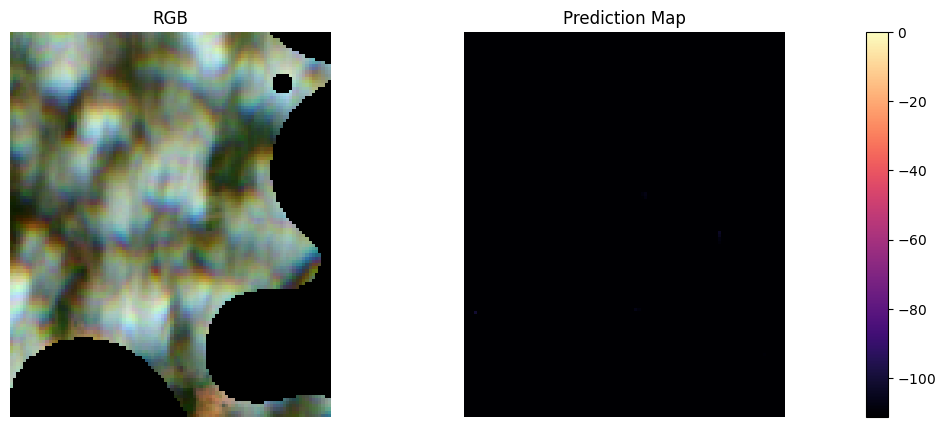

In [25]:
plot_results(prob_map=predictions_map, path_to_input_file=inference_file, task=task_type, ts_index=8)

In [26]:
predictions_map

array([[-309.24072, -303.15494, -301.22522, ..., -294.13834, -295.3028 ,
        -302.5477 ],
       [-299.62738, -304.05234, -298.0017 , ..., -292.47064, -296.0722 ,
        -301.25308],
       [-304.39792, -294.86942, -290.14432, ..., -301.17844, -301.9952 ,
        -290.00293],
       ...,
       [-345.94946, -314.83228, -310.95126, ..., -274.4402 , -267.26123,
        -257.25446],
       [-350.60352, -325.7088 , -324.731  , ..., -281.50397, -283.09875,
        -265.53186],
       [-348.542  , -319.46167, -328.24734, ..., -301.47458, -299.57126,
        -274.1403 ]], dtype=float32)